In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

df = pd.read_csv('/home/luca/SCPA/scpa_Ax/result/test.csv', delimiter=',')



In [100]:

df_cuda_csr = df[df['Mode'].str.startswith('cuda', na=False) & df['Matrix Format'].str.startswith('csr', na=False)].copy()
df_cuda_hll = df[df['Mode'].str.startswith('cuda', na=False) & df['Matrix Format'].str.startswith('hll', na=False)].copy()

df_openMp_csr = df[df['Mode'].str.startswith('openMp', na=False) & df['Matrix Format'].str.startswith('csr', na=False)].copy()
df_openMp_hll = df[df['Mode'].str.startswith('openMp', na=False) & df['Matrix Format'].str.startswith('hll', na=False)].copy()

df_openMp = df[df['Mode'].str.startswith('openMp', na=False) & df['Matrix Format']].copy()



In [101]:

cuda_hll = {}


def calcola_gflops_per_matrice_e_threads(df: pd.DataFrame, mode) -> dict:
    risultati = {}
    for matrix_name in df['Matrix Name'].unique():
        df_matrix = df[df['Matrix Name'] == matrix_name].copy()  # Usa .copy() per evitare Warning
        gflops_per_threads = {}
        if mode == "cuda":
            for threads_value in df_matrix['Threads for block'].unique():
                df_filtered = df_matrix[df_matrix['Threads for block'] == threads_value]['Measure Value']
                if not df_filtered.empty:
                    media_gflops = df_filtered.mean()  # 'Measure index' è già in GFLOPS
                    gflops_per_threads[threads_value] = media_gflops
            risultati[matrix_name] = gflops_per_threads
        else:
            for threads_value in df_matrix['Threads'].unique():
                df_filtered = df_matrix[df_matrix['Threads'] == threads_value]['Measure Value']
                if not df_filtered.empty:
                    media_gflops = df_filtered.mean()  # 'Measure index' è già in GFLOPS
                    gflops_per_threads[threads_value] = media_gflops
            risultati[matrix_name] = gflops_per_threads
    return risultati


In [102]:

def plot_performance(df, title, x_col='Threads for block', y_col='Measure Value', hue_col='Matrix Name', style_col='Mode', show_plot=True,mod="none"):

    if not df.empty:
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.lineplot(
            x=x_col,
            y=y_col,
            hue=hue_col,
            style=style_col,
            data=df,
            marker='o',
            ax=ax,
        )
        ax.set_title(title)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        if mod=="cuda":
            ax.set_xticks([2, 4, 8, 16, 32, 64, 128])
            ax.set_xlim(1, 128)
        else:
            ax.set_xticks([2, 4, 8, 16, 32, 40])
            ax.set_xlim(1, 40)

        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.set_facecolor('white')
        fig.tight_layout()
        if show_plot:
            plt.show()
    else:
        print(f"No data to plot for: {title}")




In [103]:
def calcola_media_per_threads_block(df):

    risultati = {}
    medie = df.groupby('Threads for block')['Measure Value'].mean()
    for thread, media in medie.items():
        risultati[thread] = media
    return risultati


In [104]:
def convertDictionaryIntoPandas(cuda_hll):
        # Converti il dizionario annidato in un DataFrame "lungo"
    records = []
    for matrix_name, thread_data in cuda_hll.items():
        for threads_per_block, gflops in thread_data.items():
            records.append({
                "Matrix Name": matrix_name,
                "Threads for block": threads_per_block,
                "Measure Value": gflops,
                "Mode": "cuda_hll"  # se vuoi mantenerlo costante per questo set
            })
    return pd.DataFrame(records)



In [105]:
def find_top_performance(df, group_by_cols=['Matrix Name', 'Mode'], value_col='Measure Value', max_n=1):

    if df.empty:
        return pd.DataFrame()
    return df.groupby(group_by_cols).nlargest(max_n, value_col).reset_index(drop=True)

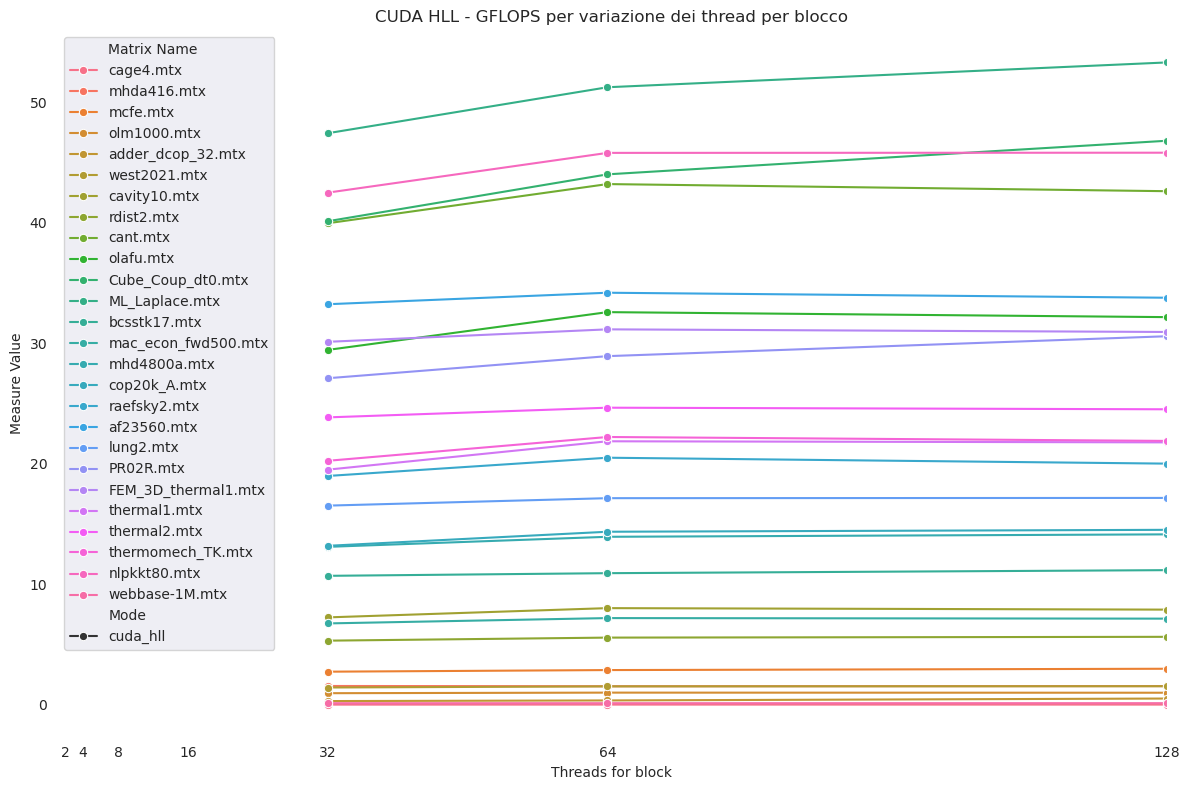

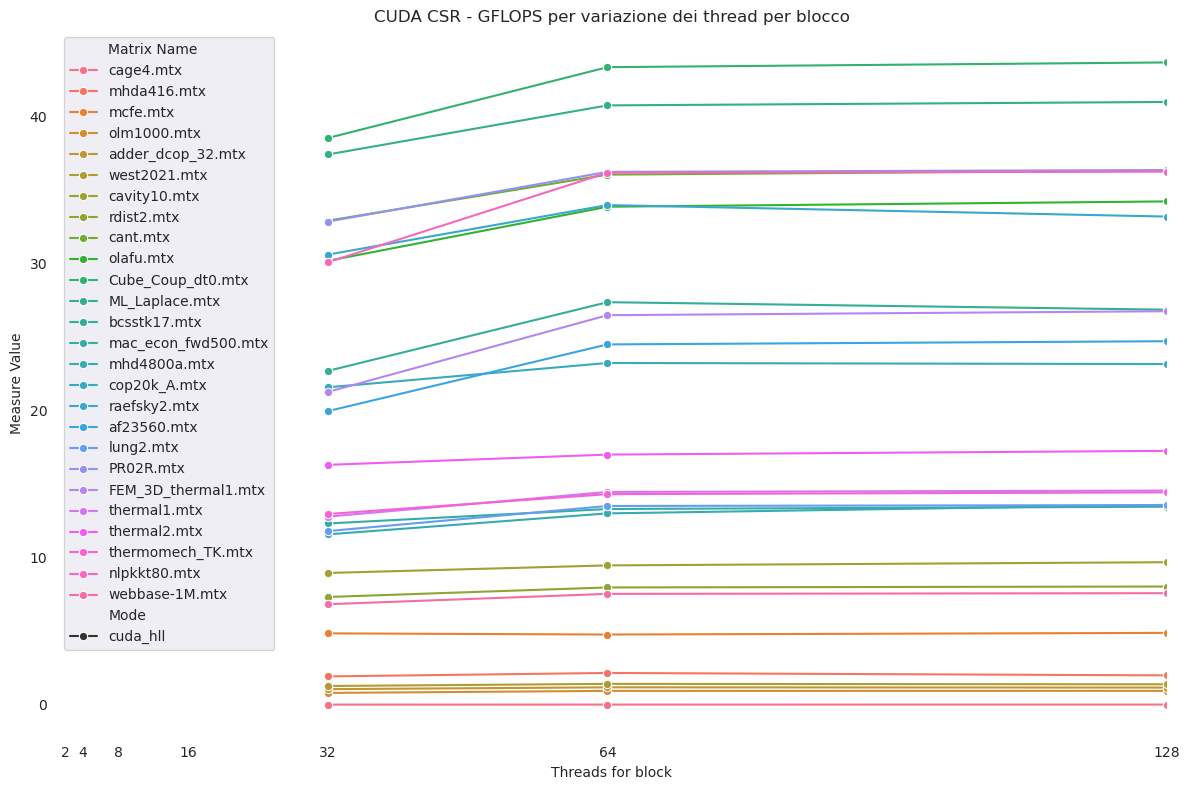

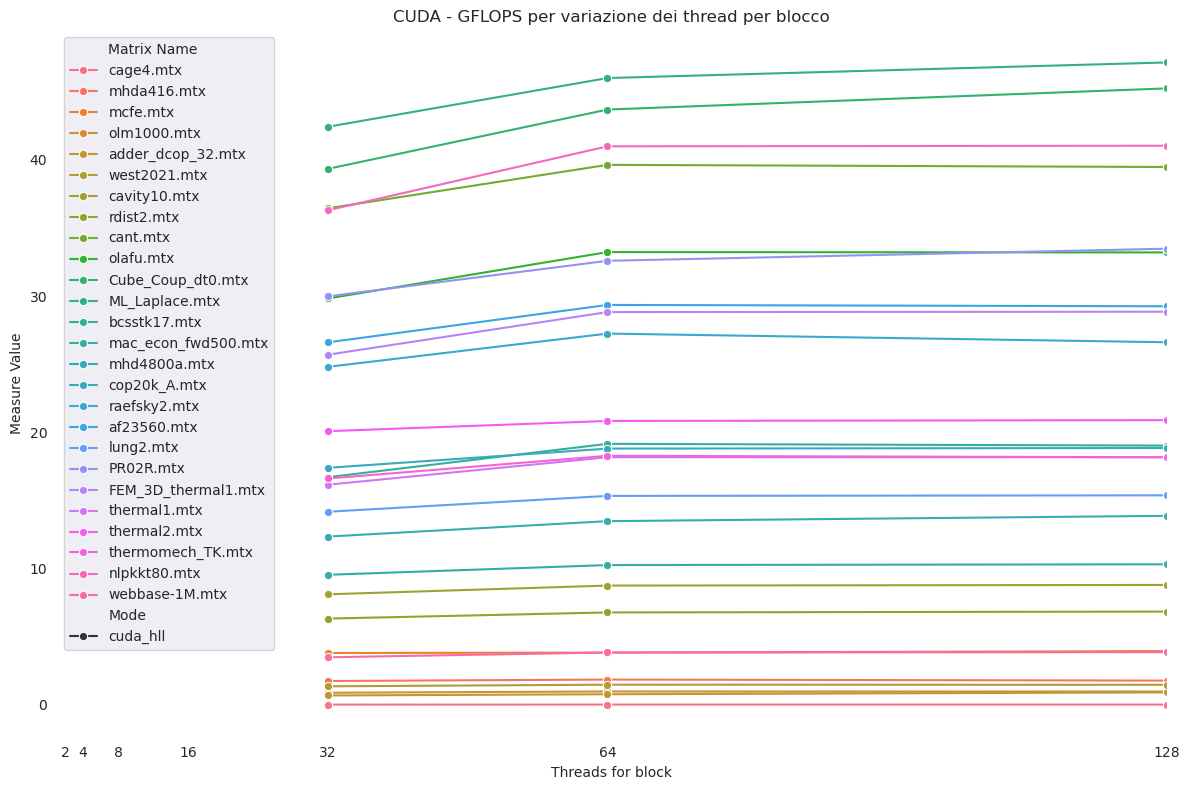

In [106]:
cuda = calcola_gflops_per_matrice_e_threads(df_cuda,"cuda")
cuda_hll = calcola_gflops_per_matrice_e_threads(df_cuda_hll,"cuda")
cuda_CSR = calcola_gflops_per_matrice_e_threads(df_cuda_csr,"cuda")



cuda_hll_df = pd.DataFrame(convertDictionaryIntoPandas(cuda_hll))
cuda_csr_df = pd.DataFrame(convertDictionaryIntoPandas(cuda_CSR))
cuda_df = pd.DataFrame(convertDictionaryIntoPandas(cuda))



plot_performance(
    df=cuda_hll_df,
    title="CUDA HLL - GFLOPS per variazione dei thread per blocco",
    x_col="Threads for block",
    y_col="Measure Value",
    hue_col="Matrix Name",
    style_col="Mode",
    mod="cuda"
)

plot_performance(
    df=cuda_csr_df,
    title="CUDA CSR - GFLOPS per variazione dei thread per blocco",
    x_col="Threads for block",
    y_col="Measure Value",
    hue_col="Matrix Name",
    style_col="Mode",
    mod="cuda"
)

plot_performance(
    df=cuda_df,
    title="CUDA - GFLOPS per variazione dei thread per blocco",
    x_col="Threads for block",
    y_col="Measure Value",
    hue_col="Matrix Name",
    style_col="Mode",
    mod="cuda"
)





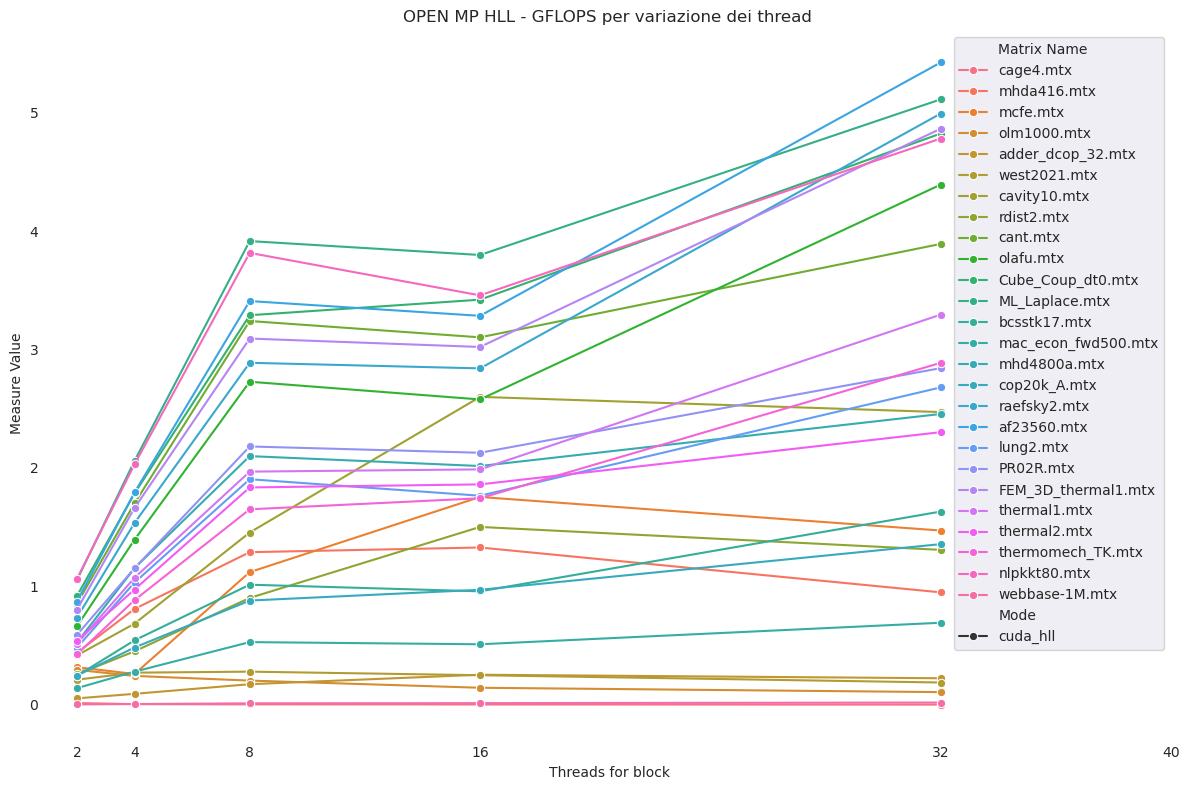

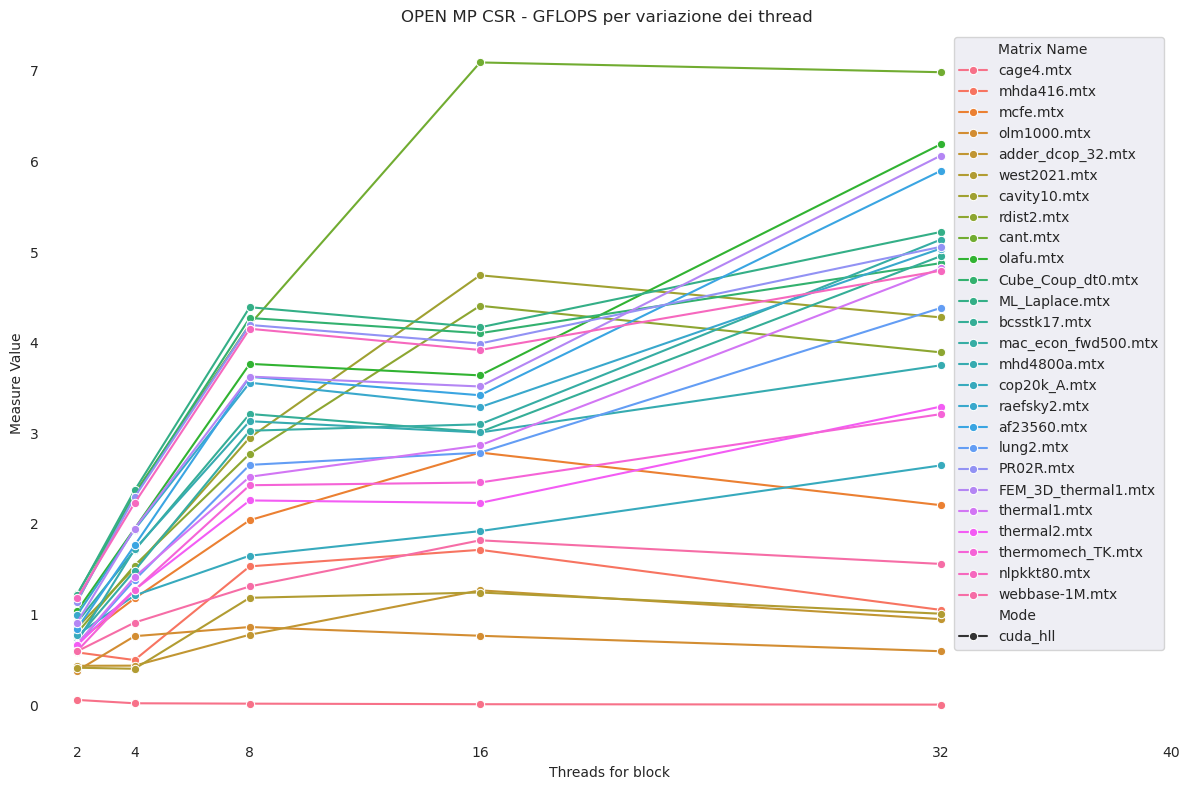

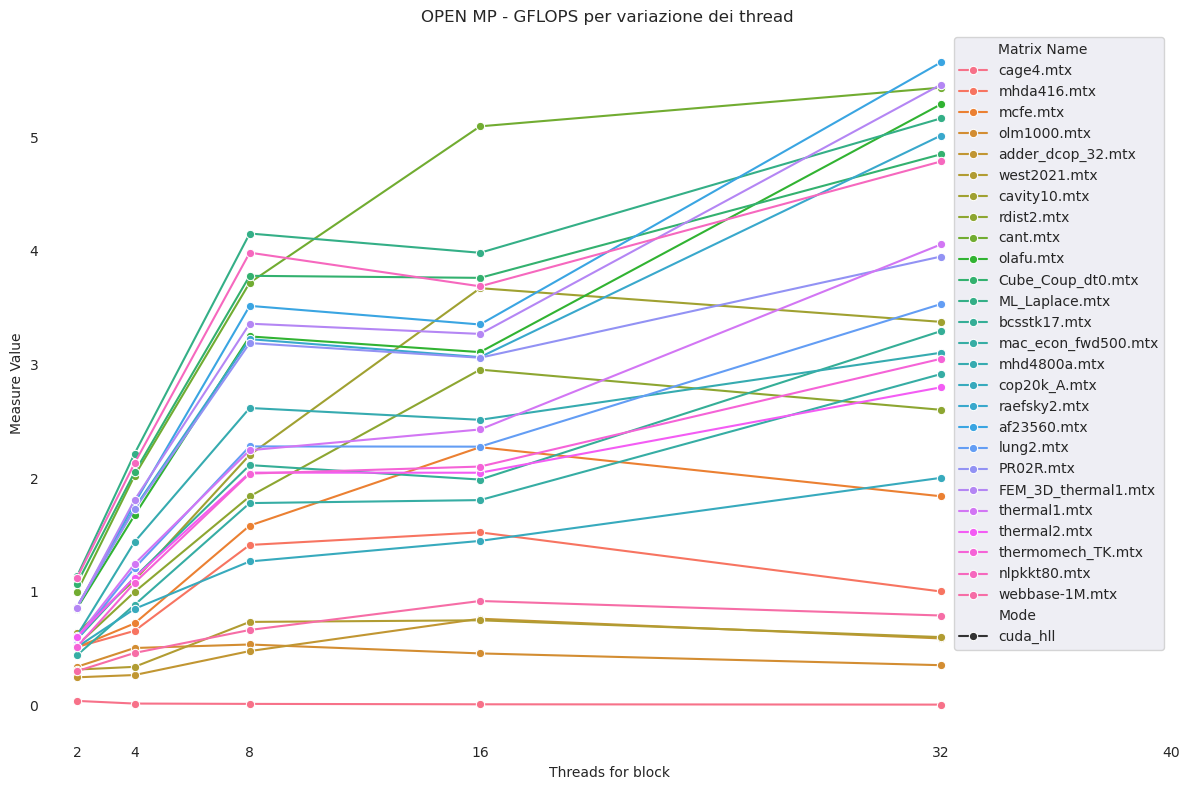

In [107]:
openMp= calcola_gflops_per_matrice_e_threads(df_openMp,"x")
openMp_hll = calcola_gflops_per_matrice_e_threads(df_openMp_hll,"x")
openMp_CSR = calcola_gflops_per_matrice_e_threads(df_openMp_csr,"x")



openMp_hll_df = pd.DataFrame(convertDictionaryIntoPandas(openMp_hll))
openMp_csr_df = pd.DataFrame(convertDictionaryIntoPandas(openMp_CSR))
openMp_df = pd.DataFrame(convertDictionaryIntoPandas(openMp))



plot_performance(
    df=openMp_hll_df,
    title="OPEN MP HLL - GFLOPS per variazione dei thread ",
    x_col="Threads for block",
    y_col="Measure Value",
    hue_col="Matrix Name",
    style_col="Mode"
)

plot_performance(
    df=openMp_csr_df,
    title="OPEN MP CSR - GFLOPS per variazione dei thread ",
    x_col="Threads for block",
    y_col="Measure Value",
    hue_col="Matrix Name",
    style_col="Mode"
)

plot_performance(
    df=openMp_df,
    title="OPEN MP - GFLOPS per variazione dei thread ",
    x_col="Threads for block",
    y_col="Measure Value",
    hue_col="Matrix Name",
    style_col="Mode"
)





In [125]:


max={}
# Troviamo il massimo per ogni matrice
max_performances = df_cuda_csr.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads for block']]
}).reset_index()

# Rinominiamo le colonne per maggiore chiarezza
max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']

# Ordiniamo per Measure Value decrescente
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)


# Troviamo il massimo per ogni matrice
max_performances = df.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads for block']]
}).reset_index()

max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)

# Visualizzazione con tabulate
print(tabulate(max_performances, headers='keys', tablefmt='pretty', floatfmt='.4f'))

+----+---------------------+------------+--------------+
|    |     Matrix Name     | Max GFLOPS | Best Threads |
+----+---------------------+------------+--------------+
| 2  |   ML_Laplace.mtx    | 62.888303  |     128      |
| 0  |  Cube_Coup_dt0.mtx  | 58.614293  |     128      |
| 16 |    nlpkkt80.mtx     | 58.246226  |      64      |
| 3  |      PR02R.mtx      | 51.569659  |      64      |
| 8  |      cant.mtx       | 49.912601  |     128      |
| 5  |     af23560.mtx     | 42.991477  |     256      |
| 17 |      olafu.mtx      | 41.253089  |     128      |
| 19 |    raefsky2.mtx     | 39.553226  |     128      |
| 1  | FEM_3D_thermal1.mtx | 38.240412  |      32      |
| 22 |    thermal2.mtx     | 34.642737  |      32      |
| 23 |  thermomech_TK.mtx  | 30.171217  |      64      |
| 6  |    bcsstk17.mtx     | 29.900251  |      64      |
| 21 |    thermal1.mtx     | 29.672417  |     128      |
| 11 |      lung2.mtx      | 29.319288  |      32      |
| 10 |    cop20k_A.mtx     | 26

In [124]:
max={}
# Troviamo il massimo per ogni matrice
max_performances = df_cuda_hll.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads for block']]
}).reset_index()

# Rinominiamo le colonne per maggiore chiarezza
max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']

# Ordiniamo per Measure Value decrescente
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)



# Troviamo il massimo per ogni matrice
max_performances = df_cuda_hll.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads for block']]
}).reset_index()

max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)

# Visualizzazione con tabulate
print(tabulate(max_performances, headers='keys', tablefmt='pretty', floatfmt='.4f'))

+----+---------------------+-------------+--------------+
|    |     Matrix Name     | Max GFLOPS  | Best Threads |
+----+---------------------+-------------+--------------+
| 2  |   ML_Laplace.mtx    |  62.888303  |     128      |
| 16 |    nlpkkt80.mtx     |  58.246226  |      64      |
| 0  |  Cube_Coup_dt0.mtx  |  54.627547  |     128      |
| 8  |      cant.mtx       |  48.870523  |      32      |
| 5  |     af23560.mtx     |  42.991477  |     256      |
| 1  | FEM_3D_thermal1.mtx |  38.240412  |      32      |
| 17 |      olafu.mtx      |  36.25557   |      32      |
| 3  |      PR02R.mtx      |  34.701601  |      32      |
| 22 |    thermal2.mtx     |  33.056127  |     128      |
| 23 |  thermomech_TK.mtx  |  30.171217  |      64      |
| 21 |    thermal1.mtx     |  29.672417  |     128      |
| 19 |    raefsky2.mtx     |  26.125355  |     128      |
| 11 |      lung2.mtx      |  24.050977  |      64      |
| 14 |    mhd4800a.mtx     |  19.971094  |     128      |
| 10 |    cop2

In [123]:
max={}
# Troviamo il massimo per ogni matrice
max_performances = df_cuda.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads for block']]
}).reset_index()

# Rinominiamo le colonne per maggiore chiarezza
max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']

# Ordiniamo per Measure Value decrescente
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)



# Troviamo il massimo per ogni matrice
max_performances = df_cuda.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads for block']]
}).reset_index()

max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)

# Visualizzazione con tabulate
print(tabulate(max_performances, headers='keys', tablefmt='pretty', floatfmt='.4f'))

+----+---------------------+-------------+--------------+
|    |     Matrix Name     | Max GFLOPS  | Best Threads |
+----+---------------------+-------------+--------------+
| 2  |   ML_Laplace.mtx    |  62.888303  |     128      |
| 0  |  Cube_Coup_dt0.mtx  |  58.614293  |     128      |
| 16 |    nlpkkt80.mtx     |  58.246226  |      64      |
| 3  |      PR02R.mtx      |  51.569659  |      64      |
| 8  |      cant.mtx       |  49.912601  |     128      |
| 5  |     af23560.mtx     |  42.991477  |     256      |
| 17 |      olafu.mtx      |  41.253089  |     128      |
| 19 |    raefsky2.mtx     |  39.553226  |     128      |
| 1  | FEM_3D_thermal1.mtx |  38.240412  |      32      |
| 22 |    thermal2.mtx     |  34.642737  |      32      |
| 23 |  thermomech_TK.mtx  |  30.171217  |      64      |
| 6  |    bcsstk17.mtx     |  29.900251  |      64      |
| 21 |    thermal1.mtx     |  29.672417  |     128      |
| 11 |      lung2.mtx      |  29.319288  |      32      |
| 10 |    cop2

In [121]:
max={}
# Troviamo il massimo per ogni matrice
max_performances = df_openMp_csr.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads']]
}).reset_index()

# Rinominiamo le colonne per maggiore chiarezza
max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']

# Ordiniamo per Measure Value decrescente
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)





# Troviamo il massimo per ogni matrice
max_performances = df_openMp_csr.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads']]
}).reset_index()

max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)

# Visualizzazione con tabulate
print(tabulate(max_performances, headers='keys', tablefmt='pretty', floatfmt='.4f'))

+----+---------------------+-------------+--------------+
|    |     Matrix Name     | Max GFLOPS  | Best Threads |
+----+---------------------+-------------+--------------+
| 8  |      cant.mtx       |  8.1240918  |      16      |
| 17 |      olafu.mtx      |  7.7248398  |      32      |
| 1  | FEM_3D_thermal1.mtx |  7.6140105  |      32      |
| 5  |     af23560.mtx     |  7.375037   |      32      |
| 19 |    raefsky2.mtx     |  6.898409   |      32      |
| 6  |    bcsstk17.mtx     |  6.7865854  |      32      |
| 12 | mac_econ_fwd500.mtx |  6.6499733  |      32      |
| 14 |    mhd4800a.mtx     |  6.2500035  |      32      |
| 3  |      PR02R.mtx      |  6.1820494  |      32      |
| 21 |    thermal1.mtx     |  6.0705361  |      32      |
| 11 |      lung2.mtx      |  5.9747186  |      32      |
| 9  |    cavity10.mtx     |  5.8798158  |      16      |
| 2  |   ML_Laplace.mtx    |  5.7249068  |      32      |
| 20 |     rdist2.mtx      |  5.466549   |      16      |
| 0  |  Cube_C

In [122]:
max={}
# Troviamo il massimo per ogni matrice
max_performances = df_openMp_hll.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads']]
}).reset_index()

# Rinominiamo le colonne per maggiore chiarezza
max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']

# Ordiniamo per Measure Value decrescente
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)


# Troviamo il massimo per ogni matrice
max_performances = df_openMp_hll.groupby('Matrix Name').agg({
    'Measure Value': ['max', lambda x: df.loc[x.idxmax(), 'Threads']]
}).reset_index()

max_performances.columns = ['Matrix Name', 'Max GFLOPS', 'Best Threads']
max_performances = max_performances.sort_values('Max GFLOPS', ascending=False)

# Visualizzazione con tabulate
print(tabulate(max_performances, headers='keys', tablefmt='pretty', floatfmt='.4f'))

+----+---------------------+------------+--------------+
|    |     Matrix Name     | Max GFLOPS | Best Threads |
+----+---------------------+------------+--------------+
| 5  |     af23560.mtx     | 7.0846318  |      32      |
| 1  | FEM_3D_thermal1.mtx | 6.5381923  |      32      |
| 8  |      cant.mtx       | 6.2850802  |      32      |
| 19 |    raefsky2.mtx     | 6.1544662  |      32      |
| 2  |   ML_Laplace.mtx    | 5.5810989  |      32      |
| 17 |      olafu.mtx      | 5.4711961  |      32      |
| 16 |    nlpkkt80.mtx     | 5.1904672  |      32      |
| 0  |  Cube_Coup_dt0.mtx  | 5.1240674  |      32      |
| 14 |    mhd4800a.mtx     | 4.1448633  |      32      |
| 21 |    thermal1.mtx     | 4.1262423  |      32      |
| 23 |  thermomech_TK.mtx  | 3.5776922  |      32      |
| 11 |      lung2.mtx      | 3.4655521  |      32      |
| 3  |      PR02R.mtx      | 3.3503807  |      32      |
| 9  |    cavity10.mtx     | 3.1546659  |      16      |
| 22 |    thermal2.mtx     | 2.